<a href="https://colab.research.google.com/github/mnoorchenar/SmartMeterData/blob/main/Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File information

File is in CSV format and contains the following columns:

1. SENSORID – Unique meter indemnifier
2. CHANTYPE – Channel Type (1 = Register Reading, 2 = Interval Reading)
3. READTS – Read Timestamp
4. VAL – Value/Reading
5. STATE – Reading Sate (3 = Actual, 5 = Estimate)
6. INTV – Interval length (Example: 60 min, 15 min, 30 min )
7. UOM – UOM (6 = KWH)
8. DIR – Direction (1 = Delivered/Consumed, 2 = Received/Generation)

In [88]:
Info_dic = {
    'SENSORID' : 'Unique meter indemnifier',
    'CHANTYPE' : 'Channel Type (1 = Register Reading, 2 = Interval Reading)',
    'READTS' : 'Read Timestamp',
    'VAL' : 'Value/Reading',
    'STATE' : 'Reading Sate (3 = Actual, 5 = Estimate)',
    'INTV' : 'Interval length (Example: 60 min, 15 min, 30 min )',
    'UOM' : 'UOM (6 = KWH)',
    'DIR' : 'Direction (1 = Delivered/Consumed, 2 = Received/Generation)'
}


In [89]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

df = pd.read_csv('https://raw.githubusercontent.com/mnoorchenar/data/main/Smart_Meter_Data/utilismart_dataset2.csv')

df.columns = df.columns.str.strip() #the .str.strip() method is used to remove any whitespace from the beginning and end of the column names
mask = df['SENSORID'].apply(lambda x: '-' not in x)
df = df[mask]
df.head()

,SENSORID,CHANTYPE,READTS,VAL,STATE,INTV,UOM,DIR
1,313960,2,01-JAN-21 05.00.00.000000000 AM,.0205,3,15,6,1
2,313960,2,01-JAN-21 05.15.00.000000000 AM,.02,3,15,6,1
3,313960,2,01-JAN-21 05.30.00.000000000 AM,.02,3,15,6,1
4,313960,2,01-JAN-21 05.45.00.000000000 AM,.0205,3,15,6,1
5,313960,2,01-JAN-21 06.00.00.000000000 AM,.02,3,15,6,1


In [90]:
# READTS – Read Timestamp
df['READTS'] = df['READTS'].replace({"-21 " : "-2021 ", "-22 " : "-2022 "}, regex = True)
df['READTS'] = df['READTS'].replace({"JAN":'01', "FEB":'02', "MAR":'03', "APR":'04', "MAY":'05', "JUN":'06', "JUL":'07', "AUG":'08', "SEP":'09', "OCT":'10', "NOV":'11', "DEC":'12'}, regex = True)
df['READTS'] = pd.to_datetime(df['READTS'], format='%d-%m-%Y %I.%M.%S.%f %p', errors='coerce')

# DIR – Direction (1 = Delivered/Consumed, 2 = Received/Generation)
df['DIR'] = pd.to_numeric(df['DIR'], errors='coerce')
print('Unique value of Direction (1 = Delivered/Consumed, 2 = Received/Generation): \n',pd.unique(df['DIR']))

# UOM – UOM (6 = KWH)
df['UOM'] = pd.to_numeric(df['UOM'], errors='coerce')
print('Unique value of UOM (6 = KWH): \n', pd.unique(df['UOM']))

df = df.dropna() #This will drop the rows where all values are NaN.

df.head()


Unique value of Direction (1 = Delivered/Consumed, 2 = Received/Generation): 
 [ 1. nan]
Unique value of UOM (6 = KWH): 
 [ 6. nan]


,SENSORID,CHANTYPE,READTS,VAL,STATE,INTV,UOM,DIR
1,313960,2,2021-01-01 05:00:00,.0205,3,15,6.0,1.0
2,313960,2,2021-01-01 05:15:00,.02,3,15,6.0,1.0
3,313960,2,2021-01-01 05:30:00,.02,3,15,6.0,1.0
4,313960,2,2021-01-01 05:45:00,.0205,3,15,6.0,1.0
5,313960,2,2021-01-01 06:00:00,.02,3,15,6.0,1.0


In [91]:
# SENSOR_ID = 313960
import plotly.graph_objs as go


def SENSORID_subset(SENSOR_ID):
  # READTS – Read Timestamp

  # SENSORID – Unique meter indemnifier
  df['SENSORID'] = pd.to_numeric(df['SENSORID'], errors='coerce')
  df_subset = df[df['SENSORID'] == SENSOR_ID]
  df_subset = df_subset.drop('SENSORID', axis=1)

  # VAL – Value/Reading
  df_subset['VAL'] = pd.to_numeric(df_subset['VAL'], errors='coerce')

  # CHANTYPE – Channel Type (1 = Register Reading, 2 = Interval Reading)
  df_subset = df_subset[df_subset['CHANTYPE'] == df_subset['CHANTYPE'].value_counts().idxmax()]
  print('Channel Type (1 = Register Reading, 2 = Interval Reading):' , df_subset['CHANTYPE'].value_counts().idxmax())
  df_subset = df_subset.drop('CHANTYPE', axis=1)

  # STATE – Reading Sate (3 = Actual, 5 = Estimate)
  df_subset = df_subset[(df_subset['STATE'].str.contains('3') | df_subset['STATE'].str.contains('5'))]
  df_subset.loc[df_subset['STATE'].str.contains('3'),'STATE'] = '0'
  df_subset.loc[df_subset['STATE'].str.contains('5'),'STATE'] = '1'
  df_subset['STATE'] = pd.to_numeric(df_subset['STATE'], errors='coerce')
  if len(df_subset['STATE'].unique())==1:
    df_subset = df_subset.drop('STATE', axis=1)
  df.rename(columns = {'STATE':'Estimated_VAL'})

  # INTV – Interval length (Example: 60 min, 15 min, 30 min )
  df_subset = df_subset[df_subset['INTV'] == df_subset['INTV'].value_counts().idxmax()]
  print('Interval length' , df_subset['INTV'].value_counts().idxmax())
  df_subset = df_subset.drop('INTV', axis=1)

  # UOM – UOM (6 = KWH)
  df_subset = df_subset[df_subset['UOM'] == df_subset['UOM'].value_counts().idxmax()]
  print('UOM (6 = KWH): ' , df_subset['UOM'].value_counts().idxmax())
  df_subset = df_subset.drop('UOM', axis=1)

  # DIR – Direction (1 = Delivered/Consumed, 2 = Received/Generation)
  df_subset = df_subset[df_subset['DIR'] == df_subset['DIR'].value_counts().idxmax()]
  print('Direction (1 = Delivered/Consumed, 2 = Received/Generation): ' , df_subset['DIR'].value_counts().idxmax())
  df_subset = df_subset.drop('DIR', axis=1)

  df_subset.reset_index(inplace=True, drop=True)

  df_subset.to_csv('SmartMeterData_ID_'+str(SENSOR_ID) + '.csv', index=False)

  #plotting
  # Define a color dictionary for each month
  colors = {'January': 'red', 'February': 'blue', 'March': 'green', 'April': 'orange', 
            'May': 'purple', 'June': 'brown', 'July': 'pink', 'August': 'gray', 
            'September': 'olive', 'October': 'cyan', 'November': 'magenta', 'December': 'black'}

  df_subset['month'] = df_subset['READTS'].dt.month_name()

  # Add a new column to the dataframe with the corresponding color for each month
  df_subset['color'] = df_subset['month'].apply(lambda x: colors[x])

  # Create an empty subplot with 1 row and 1 column
  fig = go.Figure()

  for year in pd.unique(df_subset['READTS'].dt.year):
      year_df = df_subset[df_subset['READTS'].dt.year == year]
      # Iterate over the months
      for month in range(1, max(year_df['READTS'].dt.month)):
        try:
            # Filter the dataframe to only include the current month
            month_df = year_df[year_df['READTS'].dt.month == month]
            # Add the trace to the subplot with the corresponding color
            fig.add_trace(go.Scatter(x=month_df['READTS'], y=month_df['VAL'], 
                                    name=month_df['month'].unique()[0], 
                                    mode='lines', line=dict(color=month_df['color'].unique()[0])))
        except:
          pass

  # Set the title of the subplot
  fig.update_layout(title='Time Series plot for SENSORID: '+ str(SENSOR_ID))

  # Show the plot
  fig.show()
  print(SENSOR_ID)


In [92]:
SENSOR_ID = 1017024
# SENSORID – Unique meter indemnifier
df['SENSORID'] = pd.to_numeric(df['SENSORID'], errors='coerce')
df_subset = df[df['SENSORID'] == SENSOR_ID]
df_subset = df_subset.drop('SENSORID', axis=1)

# VAL – Value/Reading
df_subset['VAL'] = pd.to_numeric(df_subset['VAL'], errors='coerce')

# CHANTYPE – Channel Type (1 = Register Reading, 2 = Interval Reading)
df_subset = df_subset[df_subset['CHANTYPE'] == df_subset['CHANTYPE'].value_counts().idxmax()]
print('Channel Type (1 = Register Reading, 2 = Interval Reading):' , df_subset['CHANTYPE'].value_counts().idxmax())
df_subset = df_subset.drop('CHANTYPE', axis=1)

# STATE – Reading Sate (3 = Actual, 5 = Estimate)
df_subset = df_subset[(df_subset['STATE'].str.contains('3') | df_subset['STATE'].str.contains('5'))]
df_subset.loc[df_subset['STATE'].str.contains('3'),'STATE'] = '0'
df_subset.loc[df_subset['STATE'].str.contains('5'),'STATE'] = '1'
df_subset['STATE'] = pd.to_numeric(df_subset['STATE'], errors='coerce')
if len(df_subset['STATE'].unique())==1:
  df_subset = df_subset.drop('STATE', axis=1)
df.rename(columns = {'STATE':'Estimated_VAL'})

# INTV – Interval length (Example: 60 min, 15 min, 30 min )
df_subset = df_subset[df_subset['INTV'] == df_subset['INTV'].value_counts().idxmax()]
print('Interval length' , df_subset['INTV'].value_counts().idxmax())
df_subset = df_subset.drop('INTV', axis=1)

# UOM – UOM (6 = KWH)
df_subset = df_subset[df_subset['UOM'] == df_subset['UOM'].value_counts().idxmax()]
print('UOM (6 = KWH): ' , df_subset['UOM'].value_counts().idxmax())
df_subset = df_subset.drop('UOM', axis=1)

# DIR – Direction (1 = Delivered/Consumed, 2 = Received/Generation)
df_subset = df_subset[df_subset['DIR'] == df_subset['DIR'].value_counts().idxmax()]
print('Direction (1 = Delivered/Consumed, 2 = Received/Generation): ' , df_subset['DIR'].value_counts().idxmax())
df_subset = df_subset.drop('DIR', axis=1)

df_subset.reset_index(inplace=True, drop=True)
df_subset.head()

Channel Type (1 = Register Reading, 2 = Interval Reading):          2
Interval length         15
UOM (6 = KWH):  6.0
Direction (1 = Delivered/Consumed, 2 = Received/Generation):  1.0


,READTS,VAL,STATE
0,2021-01-01 05:00:00,0.054,0
1,2021-01-01 05:15:00,0.053,0
2,2021-01-01 05:30:00,0.051,0
3,2021-01-01 05:45:00,0.055,0
4,2021-01-01 06:00:00,0.056,0


In [93]:
# import datetime
# date_str = "2021-01-01 05:00:00"
# df_subset['READTS'] = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

#Date and time components: Extract the year, month, day, hour, minute, and second components from the date value. These features can be useful in identifying patterns that occur on a daily, weekly, monthly, or yearly basis.
df_subset['year'] = df_subset['READTS'].dt.year
df_subset['month'] = df_subset['READTS'].dt.month
df_subset['day'] = df_subset['READTS'].dt.day
df_subset['hour'] = df_subset['READTS'].dt.hour
df_subset['minute'] = df_subset['READTS'].dt.minute
df_subset['second'] = df_subset['READTS'].dt.second

#Weekday and weekend: Extract the weekday (Monday to Sunday) from the date value. This feature can help you identify anomalies that occur on weekends or weekdays.
df_subset['weekday'] = df_subset['READTS'].dt.weekday # Monday is 0 and Sunday is 6
df_subset['is_weekend'] = df_subset['weekday'].apply(lambda x: 1 if x>=5 else 0) # weekend if weekday is 5 or 6

#Time of day: Convert the time value into a fraction of a day. This feature can help you identify anomalies that occur at certain times of the day.
df_subset['time_of_day'] = df_subset['hour'] / 24.0 + df_subset['minute'] / 1440.0 + df_subset['second'] / 86400.0

# # Time since start or end of day: Calculate the time elapsed since the start or end of the day in seconds. This feature can help you identify anomalies that occur at specific times of the day.
# df_subset['time_since_start_of_day'] = df_subset['hour'] * 3600 + df_subset['minute'] * 60 + df_subset['second']
# df_subset['time_until_end_of_day'] = (24 - df_subset['hour']) * 3600 - df_subset['minute'] * 60 - df_subset['second']

df_subset.head()


,READTS,VAL,STATE,year,month,day,hour,minute,second,weekday,is_weekend,time_of_day
0,2021-01-01 05:00:00,0.054,0,2021,1,1,5,0,0,4,0,0.208333
1,2021-01-01 05:15:00,0.053,0,2021,1,1,5,15,0,4,0,0.218750
2,2021-01-01 05:30:00,0.051,0,2021,1,1,5,30,0,4,0,0.229167
3,2021-01-01 05:45:00,0.055,0,2021,1,1,5,45,0,4,0,0.239583
4,2021-01-01 06:00:00,0.056,0,2021,1,1,6,0,0,4,0,0.250000


In [94]:
import pywt
import numpy as np

# define the wavelet function and level of decomposition
wavelet = 'db4'   # choose a wavelet function
level = 5         # choose the level of decomposition
coeffs = pywt.wavedec(df_subset['VAL'], wavelet, level=level)

# set the detail coefficients to zero to obtain an approximation of the signal
coeffs_zero = [coeffs[0]] + [np.zeros_like(coeff) for coeff in coeffs[1:]]

# perform the IDWT on the coefficients with zeroed-out detail coefficients
x_approx = pywt.waverec(coeffs_zero, wavelet)

# the length of x_approx will be the same as the original signal x
assert len(df_subset['VAL']) == len(x_approx)

# obtain the detail coefficients with the same length as the original signal
coeffs_same_size = pywt.wavedec(x_approx, wavelet, level=level)

np.sqrt(len(df_subset['VAL']))
# # the length of the detail coefficients will be the same as the original signal x
# for coeff in coeffs_same_size:
#     assert len(df_subset['VAL']) == len(coeff)

228.94104044491456

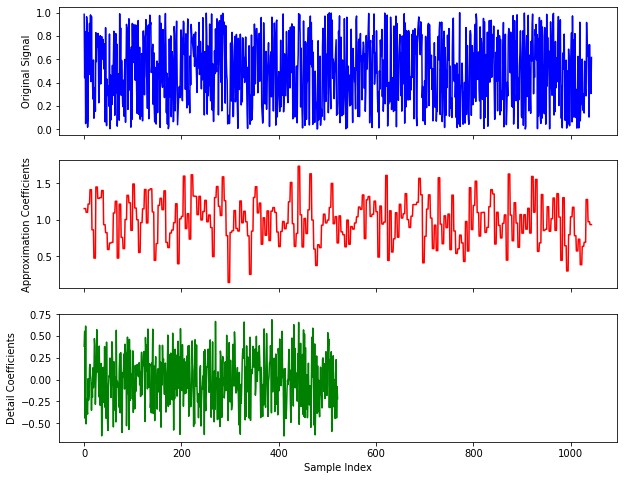

In [95]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# generate a sample signal
x = np.random.rand(1044)

# perform the DWT on the signal
wavelet = 'db1'   # choose a wavelet function
level = 2         # choose the level of decomposition
coeffs = pywt.wavedec(x, wavelet, level=level)

# extract the approximation coefficients and detail coefficients
cA, cD1, cD2 = coeffs
cA = [item for item in cA for _ in range(4)]

# plot the original signal, approximation coefficients, and detail coefficients
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(x, 'b')
axs[0].set_ylabel('Original Signal')

axs[1].plot(cA, 'r')
axs[1].set_ylabel('Approximation Coefficients')

axs[2].plot(cD2, 'g')
axs[2].set_ylabel('Detail Coefficients')

plt.xlabel('Sample Index')
plt.show()


In [96]:
print(len(cA), len(cD1), len(cD2))
261*4

1044 261 522


1044

In [97]:
len([item for item in cA for _ in range(5)])


5220

In [98]:
# plot_freq(df, 'SENSORID')
df['SENSORID'].value_counts()

313960     54832
1017024    53508
1135981    36481
1050725    25881
1049869    19306
Name: SENSORID, dtype: int64

In [99]:
SENSORIDs = df['SENSORID'].unique()
SENSORID_subset(SENSORIDs[1])
# SENSORIDs[2]

Channel Type (1 = Register Reading, 2 = Interval Reading):          2
Interval length         15
UOM (6 = KWH):  6.0
Direction (1 = Delivered/Consumed, 2 = Received/Generation):  1.0


1017024


In [101]:
weather = pd.read_csv('https://raw.githubusercontent.com/mnoorchenar/data/main/Canada_Weather/ONTARIO/CHATHAM%20KENT/en_climate_hourly_ON_6131414_01-2021_P1H.csv')
weather.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-82.08,42.31,CHATHAM KENT,6131414,2021-01-01 00:00,2021,1,1,00:00,-2.8,...,NaN,16.1,NaN,100.63,NaN,NaN,NaN,-5.0,NaN,NaN
1,-82.08,42.31,CHATHAM KENT,6131414,2021-01-01 01:00,2021,1,1,01:00,-1.7,...,NaN,16.1,NaN,100.60,NaN,NaN,NaN,-5.0,NaN,NaN
2,-82.08,42.31,CHATHAM KENT,6131414,2021-01-01 02:00,2021,1,1,02:00,-1.9,...,NaN,16.1,NaN,100.56,NaN,NaN,NaN,-5.0,NaN,NaN
3,-82.08,42.31,CHATHAM KENT,6131414,2021-01-01 03:00,2021,1,1,03:00,-2.2,...,NaN,16.1,NaN,100.60,NaN,NaN,NaN,-6.0,NaN,NaN
4,-82.08,42.31,CHATHAM KENT,6131414,2021-01-01 04:00,2021,1,1,04:00,-1.2,...,NaN,16.1,NaN,100.52,NaN,NaN,NaN,-4.0,NaN,NaN
